<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Auto_Encoding_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Auto-Encoding Variational Bayes**

논문 링크: https://arxiv.org/abs/1312.6114

Variational Auto-Encoder(VAE)는 GAN 이전에 generator model계를 주름잡고 있었던 모델이다.

**How can we perform efficient inference and learning in directed probabilistic models, in the presence of continuous latent variables with intractable posterior distributions, and large datasets?**

위의 문장은 해당 논문의 Abstract에 나와있는 첫번째 문장이다. 이 논문의 핵심이 되는 문장이라고 봐도 무방할 정도이다.

VAE의 목표는 당연히 GAN과 동일하게 sample data와 같은 분포를 학습하여 새로운 data를 생성해내는 것이다.

## **Autoencoder**

VAE를 알아보기 전에 standard autoencoder에 대해 잠깐 살펴보겠다.

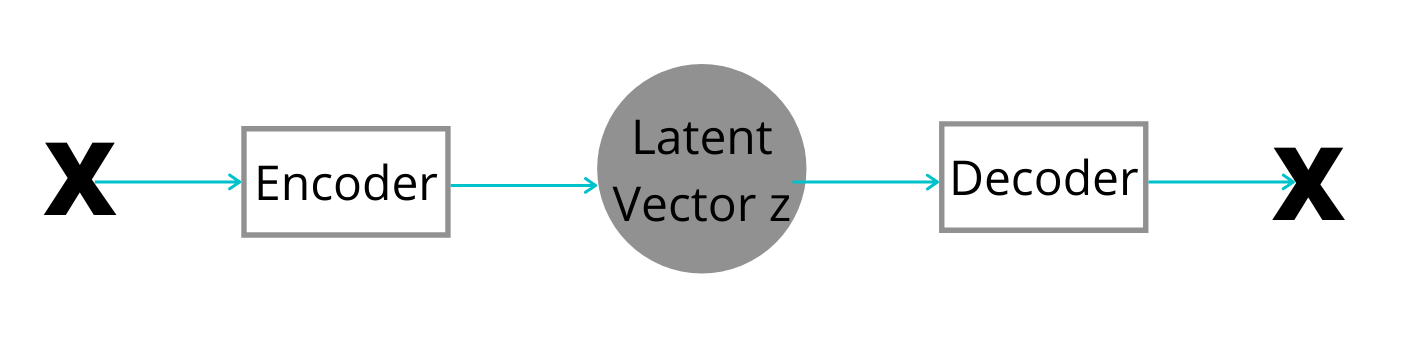

당연히 encoder과 decoder 부분으로 나뉘게 되는데, encoder는 x에서 잠재 공간 벡터 z를 생성한다. 그리고 decoder는 잠재 벡터 z에서 입력 데이터 x를 재구성한다.

하지만 한계가 존재했는데, 바로 훈련된 이미지 유형만 재구성할 수 있다는 점이다. 즉, 잠재 벡터를 생성하는 동안 데이터를 압축하고 출력을 입력에 복제하려한다. 이로 인해 autoencoder가 활용되는 주요 응용 프로그램같은 경우는 **denoising images**, **sparse reconstruvtions** 등이 있다.

또 다른 한계는 잠재 공간 벡터가 연속적이지 않다는 점이다. 즉, 출력 이미지를 입력 이미지로만 복제할 수 있다. 이러한 이유들로 인해 VAE가 나오게 되었다.

## **VAE 구조**

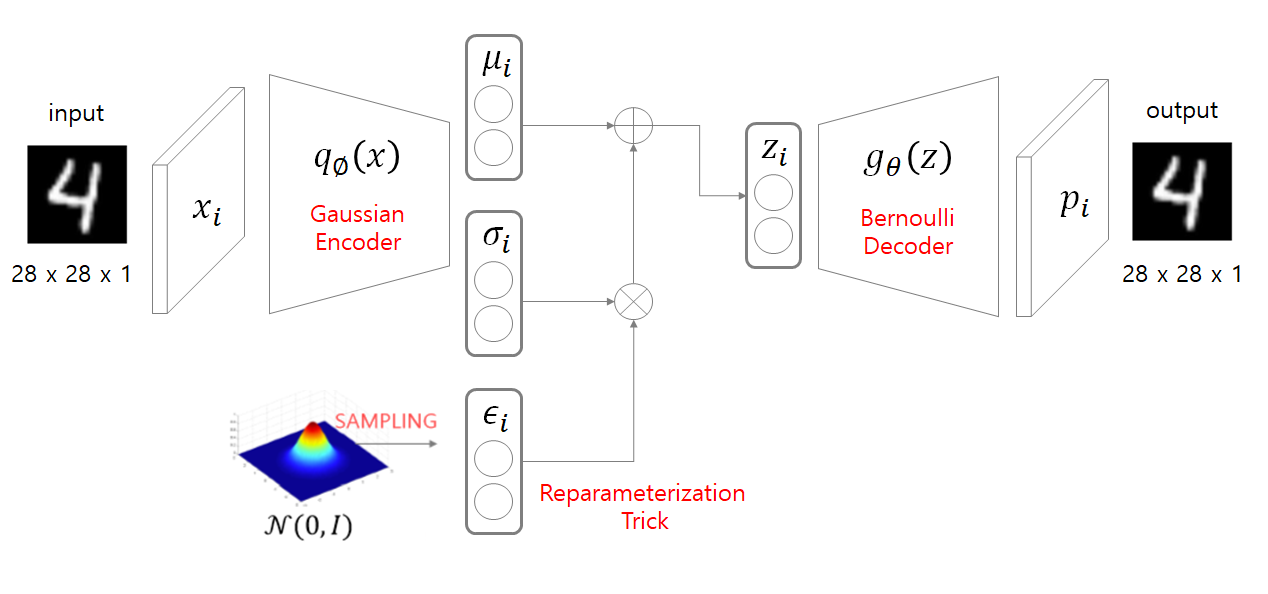

위의 그림을 단계로 설명하자면,
1. input(x) => q(∅)(x) => 𝜇(i),𝜎(𝜖)
2. 𝜇(i),𝜎(i),𝜖(i) => z(i)
3. z(i) => g(𝜃)(z(i)) => p(i)

아래에 더 자세히 서술하겠지만, 모델의 구조는 standard autoencoder와 유사하다. 주요 차이점은 **VAE에 의해 생성된 잠재 벡터는 연속적이라는 것이다.**

### **Encoder**

1. input(x) => q(∅)(x) => 𝜇(i),𝜎(𝜖)

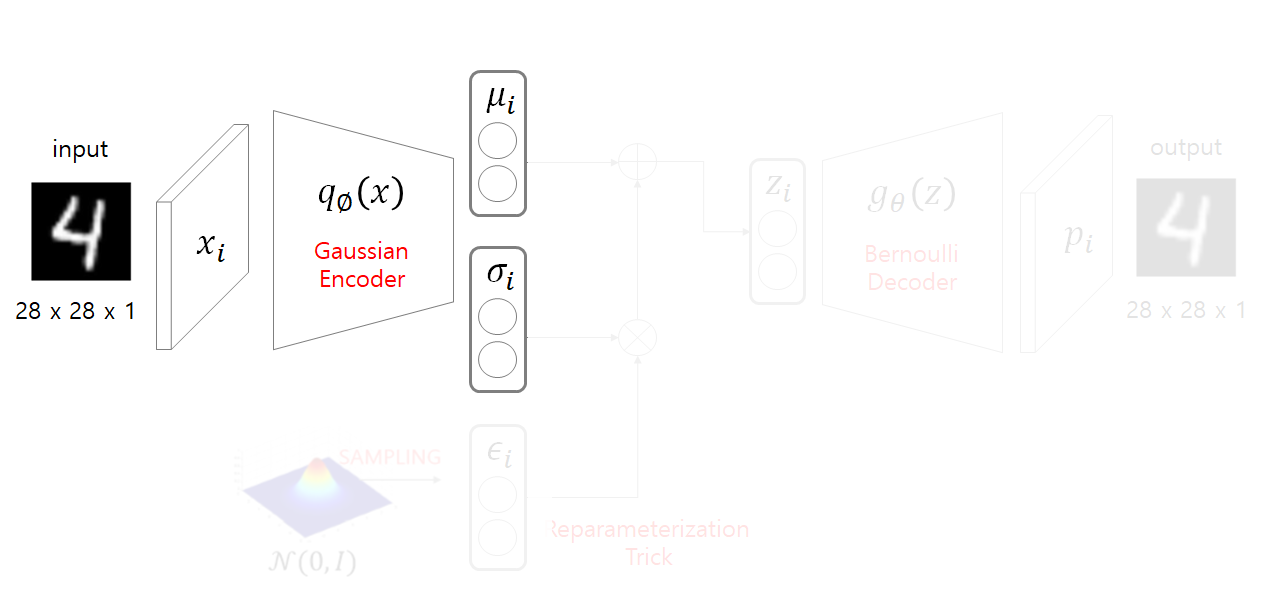

q(∅)(x)는 encoder 함수인데, x가 주어졌을때 z값의 분포의 평균과 분산을 output하는 함수이다. 즉, q 함수(= encoder)의 output은 𝜇(i),𝜎(𝜖)이다.

어떤 데이터의 특징을 x((latent variable)를 통해 추측한다. 기본적으로 여기 특징들의 분포는 normal distribution을 따른다고 가정한다. 바로 확률 분포 q(∅)(x)가 이런 특징들이 가진다. 따라서 latent space의 latent variable 값들은 q(∅)(x)의 true 분포를 approximate하는 𝜇(i),𝜎(𝜖)를 나타낸다.

### **Reparameterization Trick (Sampling)**

2. 𝜇(i),𝜎(i),𝜖(i) => z(i)

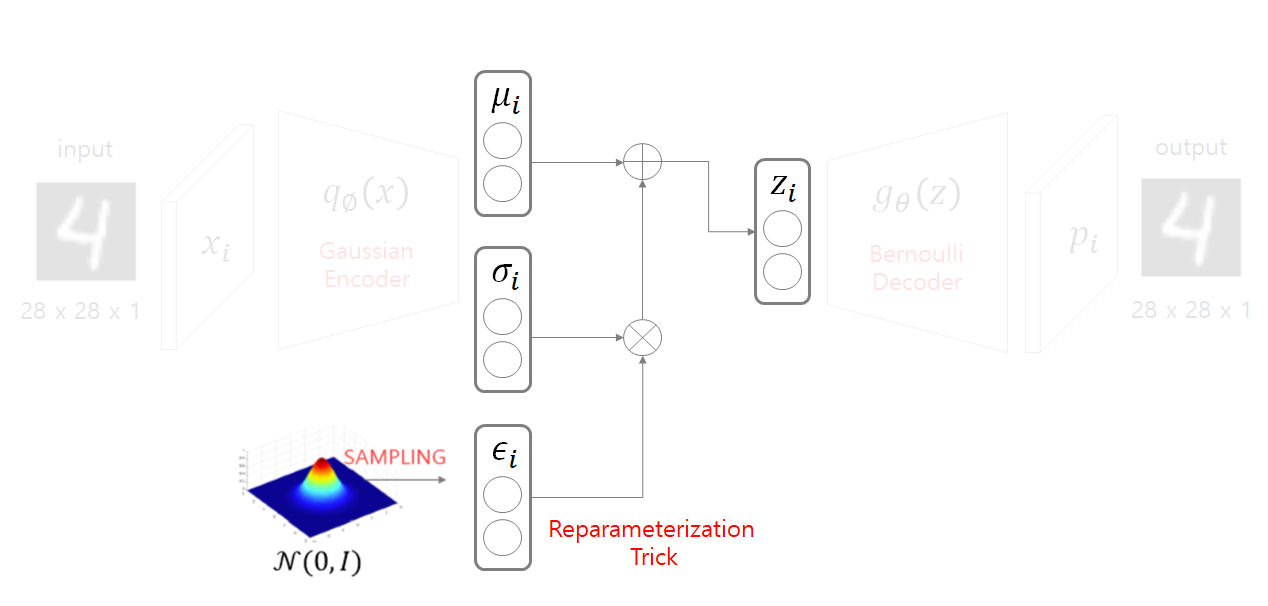

만일 encoder의 결과로 나온 값을 decoder에 넣는데 그 전에 sampling을 하지 않으면 어떻게 될까?

이런 경우는 한 값을 가지므로 그에 대한 decoder 역시 무조건 한 값만 내뱉게 된다. 하지만 VAE의 목표도 위에 말했다싶이 새로운 data를 계속 생성하는 것이기 때문에 필연적으로 sampling 과정이 필요하다. 단, 그냥 sampling을 하면 sampling 값들을 backpropagation할 수 없으므로 위의 그림과 같이 **reparameterization trick**을 활용한다.

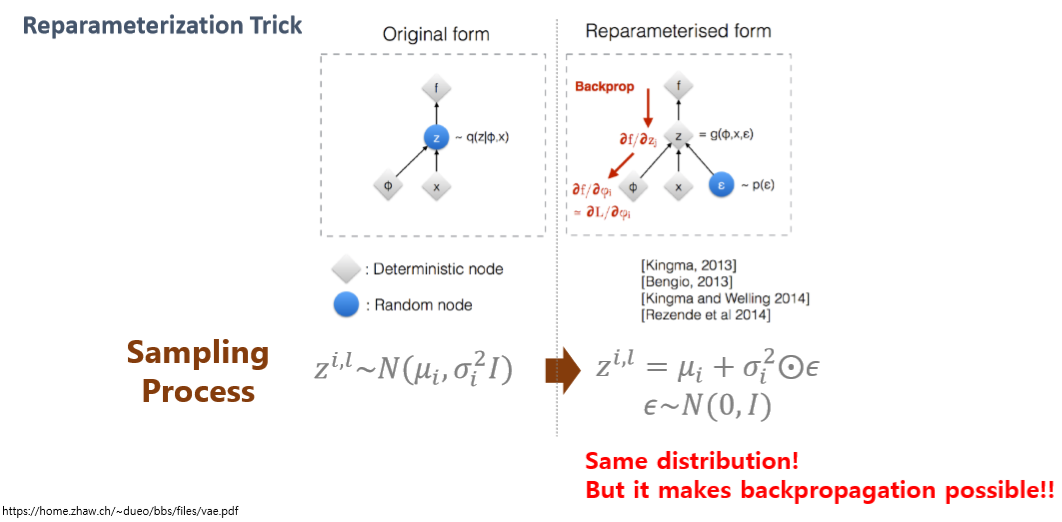

normal distribution에서 z1를 sampling하는 것이나, epsilon을 normal distribution에서 sampling하고 그 값을 분산과 곱하여 평균을 더해 z2를 만드는 것 둘다 같은 분포를 가진다. 하지만 후자의 경우는 backpropagation이 가능하다는 장점이 있다.

### **Decoder**

3. z(i) => g(𝜃)(z(i)) => p(i) = output

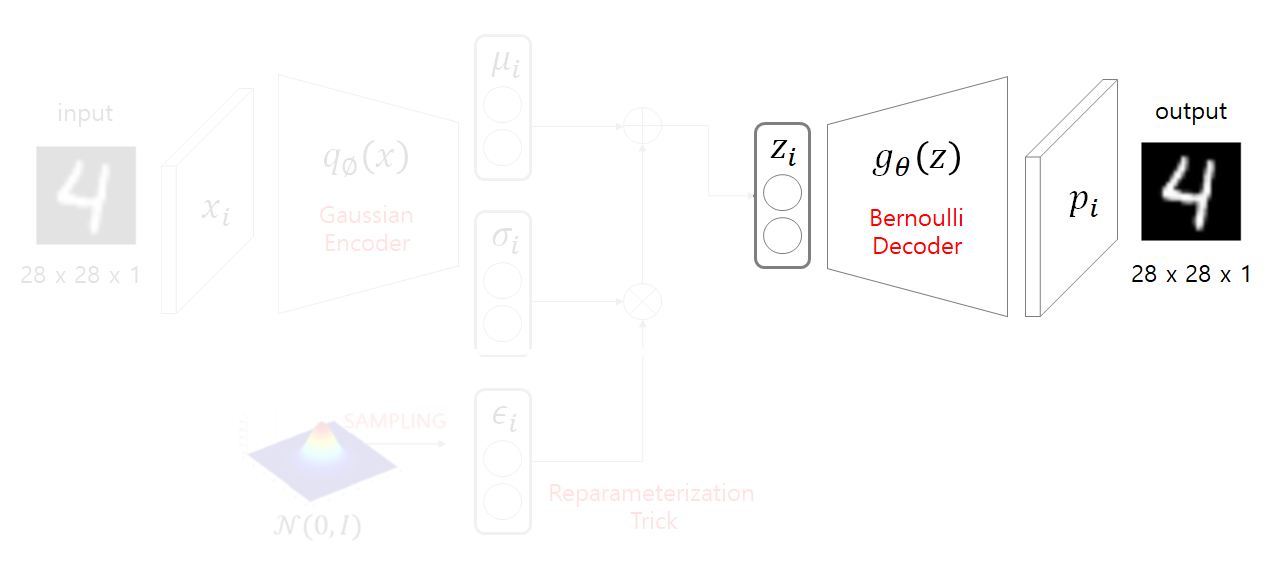

마지막으로 decoder에서 z 값을 g(𝜃) 함수에 넣고 deconv를 하여 input image의 size와 같은 output z_decoded가 나오게 된다. 이때 p(data)(x)의 분포를 **Bernoulli**로 가정했으므로 output 값은 0 ~ 1 사이의 값을 가져야하고, 이를 위해 activation function을 sigmoid로 설정했다.

(왜 분포를 Bernoulli로 가정했는지 찾아본 결과, image recognition에서 Gaussian으로 가정할 때보다 Bernoulli로 가정해야 의미상 뿐만아니라 결과상에서도 더 적절했기 때문이다. 만일 Gaussian 분포를 따른다면 아래의 loss도 다르게 설정해한다.)

### **Loss function**

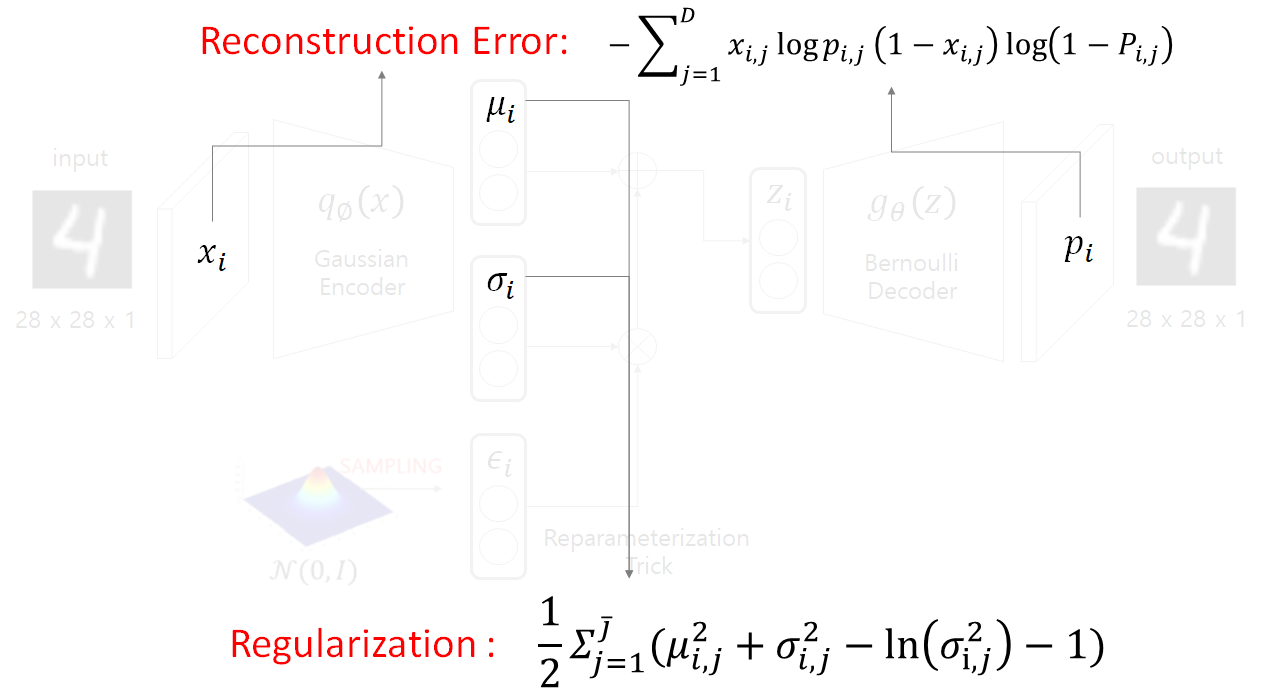

loss function은 크게 2가지가 있는데 **Reconstruction Loss**와 **Regularization Loss**가 있다.

먼저 Reconstruction Loss를 보면, Generative model이기에 당연히 새로운 x를 만들어야 하므로 x와 만들어진 output, New x와의 관계를 살핀다. 이때 decoder 부분의 pdf가 Bernoulli 분포를 따르기로 했으므로 그 둘간의 cross entropy 값을 구한다.

다음으로 Regularization Loss는 x가 원래 가지는 분포와 동일한 분포를 가지게 하기 위하여 true 분포를 approximate한 함수의 분포에 대한 loss term이다. 이때 loss는 true pdf와 approximated pdf간의 KL divergence를 계산한다.

### **Pytorch**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Linear VAE
class LinearVAE(nn.Module):
  def __init__(self, in_features=784, out_features=16):
    super(LinearVAE, self).__init__()
    
    self.out_features = out_features

    # encoder
    self.enc1 = nn.Linear(in_features=in_features, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=out_features * 2)

    # decoder
    self.dec1 = nn.Linear(in_features=out_features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=in_features)

  # mu: encoder's latent space의 평균 값
  # log_var: encoder's latent space의 로그 분산값
  def reparameterize(self, mu, log_var):
    # 표준 편차
    std = torch.exp(0.5 * log_var)
    # rand_like => std와 같은 분포가 필요하므로
    eps = torch.rand_like(std)
    # 입력 공간에서 온 것처럼 sampling
    sample = mu + (eps * std)

    return sample

  def forward(self, x):
    # encoding
    x = F.relu(self.enc1(x))
    x = self.enc2(x).view(-1, 2, self.out_features)

    # Reparameterization Trick (Sampling)
    mu = x[:, 0, :]
    log_var = x[:, 1, :]

    z = self.reparameterize(mu, log_var)

    # decoding
    x = F.relu(self.dec1(z))
    reconstruction = torch.sigmoid(self.dec2(x))
    
    return reconstruction, mu, log_var

먼저 위의 코드는 VAE의 모델을 구현한 코드이다. forward 부분을 보면 위에서 설명한대로 encoding => reparameterization => decoding 순서로 되어있는 것을 확인할 수 있다.

In [3]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [4]:
num_epoch = 10
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

MNIST 데이터셋을 회전하거나 수평으로 뒤집는 등의 data augmentation을 진행할 경우 데이터의 정보를 손실할 수 있기 때문에 ToTensor()만 사용한다.

In [6]:
dataset_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

num_data_train = len(dataset_train)

num_batch_train = np.ceil(num_data_train / batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
VAE = LinearVAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [8]:
def final_loss(bce_loss, mu, log_var):
  BCE = bce_loss
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return BCE + KLD

In [9]:
def fit(VAE, dataloader):
  VAE.train()
  running_loss = 0.0
  for i, data in tqdm(enumerate(dataloader), total=int(num_data_train / dataloader.batch_size)):
    data, _ = data
    data = data.to(device)
    data = data.view(data.size(0), -1)
    optimizer.zero_grad()
    reconstruction, mu, logvar = VAE(data)
    bce_loss = criterion(reconstruction, data)
    loss = final_loss(bce_loss, mu, logvar)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  train_loss = running_loss/len(dataloader.dataset)
  return train_loss

In [10]:
## TRAIN
st_epoch = 0
train_loss = []
for epoch in range(st_epoch+1, num_epoch+1):
  train_epoch_loss = fit(VAE, loader_train)
  train_loss.append(train_epoch_loss)
  print("TRAIN: EPOCH %04d / %04d | Train Loss: %.4f" % (epoch, num_epoch, train_epoch_loss))

938it [00:12, 77.98it/s]                         

TRAIN: EPOCH 0001 / 0010 | Train Loss: 189.8524



938it [00:11, 79.41it/s]                         

TRAIN: EPOCH 0002 / 0010 | Train Loss: 123.0158



938it [00:11, 78.85it/s]                         

TRAIN: EPOCH 0003 / 0010 | Train Loss: 112.4291



938it [00:11, 78.89it/s]                         

TRAIN: EPOCH 0004 / 0010 | Train Loss: 108.3233



938it [00:11, 79.34it/s]                         

TRAIN: EPOCH 0005 / 0010 | Train Loss: 105.6193



938it [00:11, 79.13it/s]

TRAIN: EPOCH 0006 / 0010 | Train Loss: 103.5129



938it [00:11, 78.70it/s]                         

TRAIN: EPOCH 0007 / 0010 | Train Loss: 101.8322



938it [00:11, 78.67it/s]                         

TRAIN: EPOCH 0008 / 0010 | Train Loss: 100.4221



938it [00:12, 77.48it/s]                         

TRAIN: EPOCH 0009 / 0010 | Train Loss: 99.2148



938it [00:11, 78.27it/s]                         

TRAIN: EPOCH 0010 / 0010 | Train Loss: 98.1339


위의 코드는 train을 하는 코드이다.